# Présentation
L'entreprise TouNum travaille sur la numérisation de documents (textes, images...). Leurs services sont souvent requis par des entreprises numérisant leur base de documents papier. Ils souhaitent étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, certains de leurs clients ont une grande quantité de données à numériser, et un service de catégorisation automatique serait plus que valorisable.

L'entreprise voulant automatiser la sélection de photos pour l'annotations, le livrable 1 devra fournir une méthode de classification se basant sur les réseaux de neurones afin de filtrer les images qui ne sont pas des photos du dataset de départ. La solution pourra s'appuyer sur l'architecture de réseau de neurones de notre choix, que vous justifierez notamment du point de vue des résultats obtenus.

![image](./workflow.png "Workflow")

Plusieurs dataset sont à votre disposition. Nous avons :

- Des peintures

- Des Schéma et graphes

- Des portraits dessinés en noir et blanc

- Des images de textes scannés

- Des photos
 
Les images ne sont pas étiquetées, mais ce n'est pas un problème puisqu'elles sont réparties dans des archives différentes.

# Choix du modèle

L'architecture de réseau de neurones convolutifs (CNN) profonde est bien adaptée à notre tâche de classification d'images variées, telles que des peintures, des schémas, des portraits en noir et blanc, des textes scannés et des photos. Les CNN sont reconnus pour leur capacité à extraire des caractéristiques discriminantes des images, même en l'absence d'étiquettes.

De plus, ce modèle intègre des couches de régularisation et de dropout, contribuant à la robustesse du modèle en réduisant le risque de surapprentissage, un élément essentiel étant donné que nos données ne sont pas étiquetées. Les couches de prétraitement, notamment la normalisation et l'augmentation des données, améliorent également la capacité du modèle à généraliser face à des variations dans les images.

La fonction d'activation 'relu' et la perte SparseCategoricalCrossentropy sont des choix appropriés pour notre tâche de classification d'images, favorisant la convergence de l'apprentissage et la distinction entre les différentes catégories d'images. En somme, ce modèle représente une solution solide pour automatiser notre sélection de photos dans des données non étiquetées, répondant ainsi à nos besoins en matière de catégorisation automatique d'images.

## Import des librairies

In [9]:
!pip install pandas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import pickle
import tensorflow as tf
import glob
import zipfile

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/de/ce/b5d9c7ce1aaf9023b823c81932a50cd5e8f407198a696b0d1c6025a40b03/pandas-2.1.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/32/4d/aaf7eff5deb402fd9a24a1449a8119f00d74ae9c2efa79f8ef9994261fc2/pytz-2023.3.post1-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 21.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 16.5 MB/s eta 0:00:00


2023-10-11 12:47:23.514772: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-11 12:47:23.514825: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-11 12:47:23.517043: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-11 12:47:23.700048: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Import des données

Pour commencer, nous devons spécifier quelques paramètres pour l'apprentissage:
<ul>
    <li>La longueur et la largeur des images. </li>
    <li>La taille du batch.</li>
</ul>

In [25]:
image_h = 128
image_w = 128
batch_s = 128
data_dir = './Data'

## Décompression des dossiers ZIP

In [11]:
for file in os.listdir():
    if file.endswith('.zip'):
        zip_ref = zipfile.ZipFile(file, 'r')
        zip_ref.extractall('./Data')
        zip_ref.close()

## Vérification des images

In [16]:
img_paths = glob.glob("./Data/*/*.*")

bad_paths = []

for image_path in img_paths:
    try:
        img_bytes = tf.io.read_file(image_path)
        decoded_img = tf.io.decode_image(img_bytes)
    except tf.errors.InvalidArgumentError as e:
        print(f"Found bad path {image_path}...{e}")
        bad_paths.append(image_path)

print(f"{image_path}: OK")

print("BAD PATHS:")
for bad_path in bad_paths:
    print(f"{bad_path}")
    os.remove(bad_path)

2023-10-11 13:05:10.996844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


./Data/Text/text_05719.jpg: OK
BAD PATHS:


## Création des dossiers

Nous allons déplacer les images qui ne sont pas des photos dans un dossier nommé "NotPhotos". Nous allons également déplacer les images qui sont des photos dans un dossier nommé "Photos".

In [21]:
os.mkdir(os.path.join(data_dir, 'NotPhoto'))
for folder in os.listdir(data_dir):
    if folder != 'Photo' and folder != 'NotPhoto':
        for file in os.listdir(os.path.join(data_dir, folder)):
            os.rename(os.path.join(data_dir, folder, file), os.path.join(data_dir, 'NotPhoto', file))
        os.rmdir(os.path.join(data_dir, folder))

## Création des dataset

Nous utilisons TensorFlow pour charger notre ensemble de données depuis le répertoire spécifié. Nous le divisons en ensembles d'entraînement (train_set) et de validation (test_set) avec une répartition de 80% pour l'entraînement et 20% pour la validation. Les images sont redimensionnées à la taille spécifiée, et un batch size est défini pour former des mini-lots lors de l'entraînement du modèle. Cette préparation des données est essentielle pour garantir un flux efficace de données vers notre modèle de classification d'images.

In [26]:
dossier_dataset = data_dir
data_dir = dossier_dataset

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
)


Found 41398 files belonging to 2 classes.
Using 33119 files for training.
Found 41398 files belonging to 2 classes.
Using 8279 files for validation.


## Visualisation des données

Nous vérifions que les données sont bien labellisées.

In [27]:
class_names = test_set.class_names
print(class_names)

['NotPhoto', 'Photo']


Nous affichons quelques images de notre ensemble de données pour vérifier qu'elles sont correctement chargées et étiquetées.

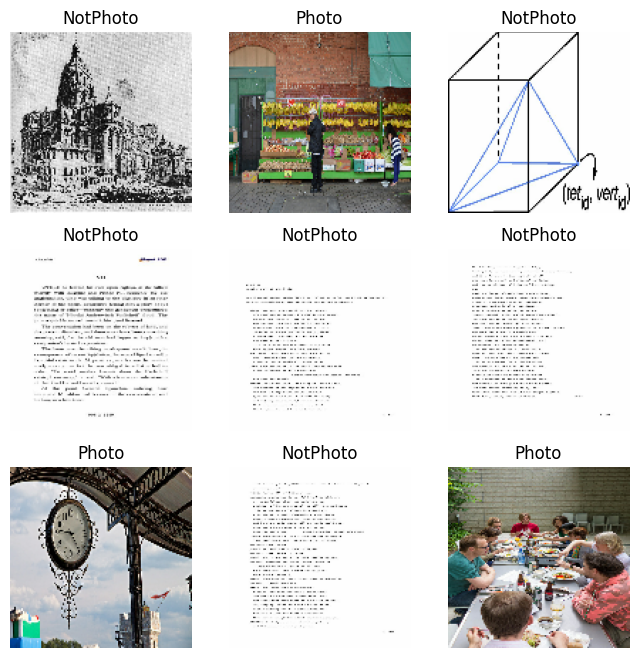

In [28]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Nous affichons également le nombre d'images dans chaque ensemble de données.

In [29]:
print(type(train_set))
images, labels = next(iter(train_set))
print(images.shape)
print(labels.shape)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
(128, 128, 128, 3)
(128,)


# Configuration de l'environnement pour l'entrainement

Dans cette partie, Nous utilisons les fonctions Dataset.cache et Dataset.prefetch afin de configurer les données pour améliorer les performances de la façon suivante :

- Dataset.cache() : Cette fonction sert à forcer le maintien des données en cache dans la mémoire. Vu que le réseau de neurones fait plusieurs passes (qu'on nomme époque ou epoch en anglais) sur les données durant l'apprentissage, cette fonction permet de ne pas avoir à recharger les images à chaque fois.

- Dataset.prefetch() : Cette fonction permet de faire le prétraitement de l'élément courant du jeu de données (par exemple le batch suivant) en même temps que l'entrainement/évaluation du batch courant par le modèle. Dans un environnement multi-processeurs ou multi-cœur, c'est un gain de temps non négligeable.

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

## Techniques de régularisation

Les techniques de régularisation sont les techniques qui visent à réduire le surapprentissage. L’objectif est d’éviter que le réseau de neurones mémorise le jeu de données en s’ajustant bêtement sur les particularités du jeu d’entrainement. Il s’agit globalement de réduire les degrés de liberté du réseau de neurones.

Les techniques de régularisation sont les techniques qui visent à réduire le surapprentissage. L’objectif est d’éviter que le réseau de neurones mémorise le jeu de données en s’ajustant bêtement sur les particularités du jeu d’entrainement. Il s’agit globalement de réduire les degrés de liberté du réseau de neurones.

Avoir plus de données est toujours bon pour réduire le surapprentissage, d’où l’augmentation des données. Le principe et de rajouter de nouvelles images en effectuant des transformations sur le jeu d’entrainement d’origine. Ces nouvelles images sont obtenues par des transformation affines, ou généralement par des transformations réalistes qui ne change pas la nature du label affectée à l’image. Cette technique est très efficace car les réseaux de neurones sont très gourmands en données.

In [32]:
from keras.src.layers.preprocessing.image_preprocessing import HORIZONTAL_AND_VERTICAL
from keras.src.layers.preprocessing.image_preprocessing import RandomFlip
from keras.src.layers.preprocessing.image_preprocessing import RandomRotation
from keras.src.layers.preprocessing.image_preprocessing import RandomZoom
from keras import Sequential

data_augmentation = Sequential(
    [
        RandomFlip(
            mode=HORIZONTAL_AND_VERTICAL,
            input_shape=(image_h, image_w, 3)),
        RandomRotation(
            factor=0.18,
            fill_mode='reflect',
            interpolation='bilinear',
            seed=None,
            fill_value=0.0),
        RandomZoom(
            height_factor=0.1,
            width_factor=None,
            fill_mode='reflect',
            interpolation='bilinear',
            seed=None,
            fill_value=0.0)
    ]
)

# Création du modèle

Nous commençons par définir le nombre de d'epochs et d'autres paramètres.

In [34]:
epochs = 100
num_classes = len(class_names)
regularizer_rates = [0.001]
all_train, all_test = list(), list()

Nous avons fait le choix d'une classification binaire, distinguant entre "photo" et "NotPhoto", en nous appuyant sur ce modèle pour plusieurs raisons pertinentes. Tout d'abord, cette approche simplifie considérablement la tâche de catégorisation, car nous cherchons principalement à identifier la présence ou l'absence de photos au sein de nos données. De plus, elle permet de répondre de manière efficace à un besoin spécifique de l'entreprise TouNum, qui cherche à automatiser la sélection de photos parmi divers types d'images.

Nous utilisons la fonction Sequential de Keras pour créer notre modèle. Nous commençons par ajouter une couche de prétraitement pour normaliser les valeurs de pixels de nos images. Nous ajoutons ensuite une couche de convolution avec une fonction d'activation 'relu' et une couche de pooling pour extraire les caractéristiques des images. Nous ajoutons ensuite deux couches de convolution supplémentaires, suivies d'une couche de dropout pour réduire le surapprentissage. Nous ajoutons ensuite une couche de mise à plat et deux couches denses pour la classification. La couche de sortie utilise une fonction d'activation 'sigmoid' pour la classification binaire.

L'Early Stopping joue un rôle essentiel dans notre processus d'entraînement, garantissant que notre modèle ne soit pas surajusté aux données d'entraînement, ce qui pourrait compromettre sa capacité à généraliser sur de nouvelles images non étiquetées. En surveillant la performance sur l'ensemble de validation et en arrêtant l'entraînement lorsque la performance stagne, nous nous assurons que notre modèle atteint un équilibre optimal entre la capacité à apprendre des données d'entraînement et la capacité à bien généraliser sur des images inconnues. Cette approche contribue à la robustesse de notre modèle de classification binaire, lui permettant d'automatiser efficacement la sélection de photos dans un ensemble de données diversifié.

In [35]:
from tensorflow.keras import layers

for rate in regularizer_rates :
    complete_model =  Sequential([
        data_augmentation,
        layers.experimental.preprocessing.Rescaling(1./255),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(rate)),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(rate)),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(rate)),
        layers.MaxPooling2D(),
        layers.Dropout(0.1),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid') # 2 classes => sigmoid /// sinon softmax
    ])
    
    complete_model.build((None, image_h, image_w, 3))
    
    # Compilation du modèle
    complete_model.compile(optimizer =  tf.keras.optimizers.Adam(),
                           loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                           metrics=['accuracy'])
    # Résumé du modèle
    complete_model.summary()

    # early stopping 

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=10,
        restore_best_weights=True)

    # Entrainement du modèle
    history =  complete_model.fit(
        train_set,
        validation_data=test_set,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    # Evaluation du modèle
    _, train_acc = complete_model.evaluate(train_set, verbose=0)
    _, test_acc = complete_model.evaluate(test_set, verbose=0)
    print('Param: %f, Train: %.3f, Test: %.3f' % (rate, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                 

/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-10-11 13:53:17.830635: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-11 13:53:27.957435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 26 of 1000
2023-10-11 13:53:37.994372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 62 of 1000
2023-10-11 13:53:48.026687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDa

259/259 [==============================] - ETA: 0s - loss: 0.4491 - accuracy: 0.8016

2023-10-11 13:56:30.996032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


259/259 [==============================] - 210s 467ms/step - loss: 0.4491 - accuracy: 0.8016 - val_loss: 0.3572 - val_accuracy: 0.8373
Epoch 2/100
259/259 [==============================] - 98s 378ms/step - loss: 0.3595 - accuracy: 0.8381 - val_loss: 0.3405 - val_accuracy: 0.8464
Epoch 3/100
259/259 [==============================] - 99s 381ms/step - loss: 0.3230 - accuracy: 0.8602 - val_loss: 0.3258 - val_accuracy: 0.8699
Epoch 4/100
259/259 [==============================] - 99s 382ms/step - loss: 0.2970 - accuracy: 0.8776 - val_loss: 0.3062 - val_accuracy: 0.8674
Epoch 5/100
259/259 [==============================] - 99s 383ms/step - loss: 0.2808 - accuracy: 0.8855 - val_loss: 0.2958 - val_accuracy: 0.8717
Epoch 6/100
259/259 [==============================] - 99s 383ms/step - loss: 0.2665 - accuracy: 0.8918 - val_loss: 0.3027 - val_accuracy: 0.8667
Epoch 7/100
259/259 [==============================] - 98s 380ms/step - loss: 0.2604 - accuracy: 0.8960 - val_loss: 0.3196 - val_accura

# Mesure de performance du modèle

Avant d'afficher les résultats de précision sur les ensembles d'entraînement et de test, nous évaluons le modèle pour quantifier sa performance. Ces mesures fournissent une indication de la capacité du modèle à bien généraliser et à éviter le surapprentissage, en complément des valeurs déjà collectées pour différentes configurations de régularisation.

In [36]:
all_train
all_test

[0.9136369228363037]

Une précision de 0.91 (ou 91%) sur les données d'entraînement ou de test est un résultat prometteur. Cela signifie que le modèle est capable de classer correctement 90% des échantillons dans l'ensemble de données correspondant.

## Visualisation de la performance du modèle

Ce code réalise une analyse visuelle de la performance du modèle au fil du temps, en traçant les courbes d'entraînement et de validation de l'accuracy (précision) ainsi que de la perte (loss). L'accuracy mesure la proportion d'images correctement classées, tandis que la perte (loss) indique l'erreur du modèle pendant l'entraînement.

Les deux premiers graphiques montrent l'évolution de l'accuracy, tant pour l'ensemble d'entraînement que pour l'ensemble de validation, au fur et à mesure des époques d'entraînement. L'objectif est d'observer si le modèle apprend efficacement (l'accuracy augmente) et s'il généralise correctement (l'accuracy sur l'ensemble de validation suit une tendance similaire).

Les deux graphiques du bas représentent les courbes de perte, à la fois pour l'entraînement et la validation. La perte diminue au fil des époques, ce qui signifie que le modèle s'ajuste de mieux en mieux aux données. L'ensemble de validation est utilisé pour évaluer si le modèle évite le surapprentissage en surveillant la divergence entre la perte d'entraînement et la perte de validation.

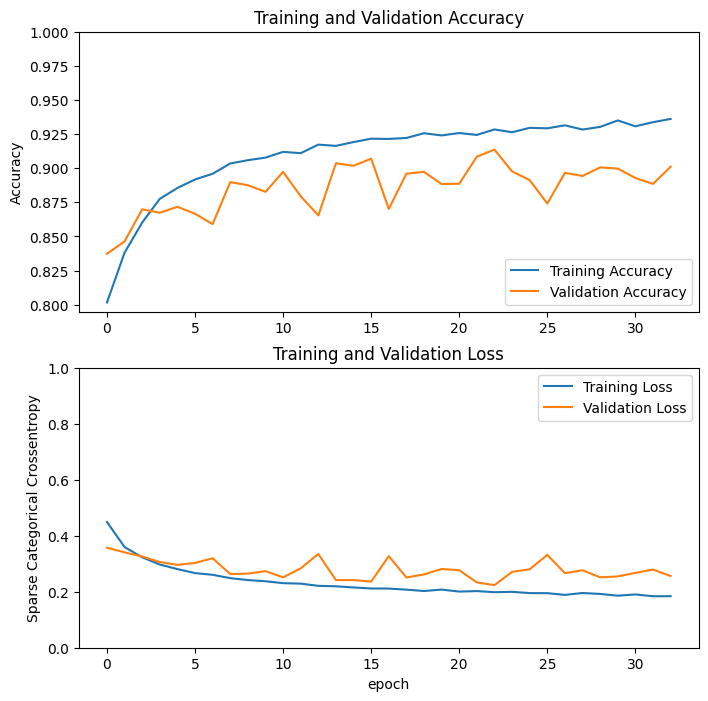

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot de l'accuracy et de la loss
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse Categorical Crossentropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

La courbe d'accuracy d'entraînement augmente rapidement au cours des premières époques, puis se stabilise, ce qui indique que le modèle apprend efficacement les données d'entraînement. La courbe d'accuracy de validation suit une tendance similaire, ce qui indique que le modèle généralise bien sur de nouvelles images.